## Investigate a Dataset  - Project 5 of Intro to Programming Nanodegree

### Variables Affecting Hall of Fame Induction

For my project, I am investigating the baseball dataset, specifically the variables affecting Hall of Fame induction for non-pitchers and whether this data might reveal something about how the game has changed over time. I will present summary batting statistics for four groups: 1.) Hall of Famers in the modern era (1969-present); 2.) Hall of Famers in the pre-modern era; 3.) a random sample of non-Hall of Famers in the modern era; and 4.) a radnom sample of non-Hall of Famers in the pre-modern era. The random samples will be equivalent to the number of Hall of Famers in the given category. For example, if the pre-modern Hall of Fame group contains 100 players, then the random sample of pre-modern, non-Hall of Famers will also contain 100 players. 

In addition, I will provide a variety of charts and graphs to illustrate the comparisons, beginning with summary statistics for each group, followed by KDE curves for batting average and on-base-percentage, and finally scatterplots showing batting average vs. homeruns.

In [1]:
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import date
from dateutil.parser import parse

# Read .csv files into dataframes; parse dates for 'debut' and 'finalGame' in master.csv
batting_df = pd.read_csv('batting.csv')
hof_df = pd.read_csv('halloffame.csv')
parse_dates_master = ['debut', 'finalGame']
master_df = pd.read_csv('master.csv', parse_dates=parse_dates_master)
pitching_df = pd.read_csv('pitching.csv')

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Remove pitchers from the batting data; thanks to Myles Callan, Udacity Forum mentor, for advice on .isin()
pitcher_list = pitching_df.playerID.unique()
batting_no_pitchers = batting_df[~(batting_df['playerID'].isin(pitcher_list))].copy()
# Create batting data for hall of fame players only 
hof_players_df = hof_df[(hof_df.inducted == 'Y') & (hof_df.category == 'Player')]
hof_list = hof_players_df.playerID.unique()
hof_batting = batting_no_pitchers[batting_no_pitchers['playerID'].isin(hof_list)].copy()

In [3]:
# merge data into a two files: player_data and hof_player_data; replace NaN's in 'HBP' & 'SF' with 0
player_data = batting_no_pitchers.merge(master_df, on='playerID', how='left')
hof_player_data = hof_batting.merge(master_df, on='playerID', how='left')
player_data['HBP'].fillna(0, inplace=True)
player_data['SF'].fillna(0, inplace=True)
hof_player_data['HBP'].fillna(0, inplace=True)
hof_player_data['SF'].fillna(0, inplace=True)

#### The Modern Era
Baseball has changed significantly over the years. Therefore, many people separate the modern era from the pre-modern because comparisons of players across the times yields a somewhat "apples and oranges" comparison. In his article, ["Drawing the Line at 1969"](http://www.espn.com/mlb/columns/story?columnist=stark_jayson&id=2471349 "ESPN.com"), Jayson Stark of ESPN.com makes the case for 1969 as the beginning of the "Modern Era" of baseball.  His reasoning was that it was as follows: "First year of division play and the expanded postseason. Pitcher's mound lowered five inches. Strike zone shrinks. Five-man rotations kicking in. The save is invented. More expansion. Unbalanced schedules." For the puposes of this investigation, I will use Jayson Stark's delineation of 1969 as the beginning of the modern era. All players who debuted prior to 1969 will be considered pre-modern and vice versa for those who debuted after 1969.

In [4]:
# separate modern and non-modern players; modern era taken as any player whose debut occurred after 1/1/1969
modern_era_date = parse('1969-01-01')
modern_players = player_data[(player_data.debut > modern_era_date) & (player_data.AB >= 100)].copy()
modern_hof_players = hof_player_data[(hof_player_data.debut > modern_era_date) & (hof_player_data.AB >= 100)].copy()
pre_modern_players = player_data[(player_data.debut < modern_era_date) & (player_data.AB >= 100)].copy()
pre_modern_hof_players = hof_player_data[(hof_player_data.debut < modern_era_date) & (hof_player_data.AB >= 100)].copy()

In [5]:
# Sum the batting stats for players and calculate career batting average and on-base percentage
sum_batting_modern = modern_players.groupby('playerID')['AB', 'H', 'HR', 'BB', 'HBP', 'SF'].sum()
sum_hof_batting_modern = modern_hof_players.groupby('playerID')['AB', 'H', 'HR', 'BB', 'HBP', 'SF'].sum()
sum_batting_pre_modern = pre_modern_players.groupby('playerID')['AB', 'H', 'HR', 'BB', 'HBP', 'SF'].sum()
sum_hof_batting_pre_modern = pre_modern_hof_players.groupby('playerID')['AB', 'H', 'HR', 'BB', 'HBP', 'SF'].sum()
# Create functions to calculate batting average and on base percentage
# takes dataframe with career batting stats and returns batting average per player
def get_batting_average(sum_batting):
    if sum_batting['AB'] != 0:
        return sum_batting['H'] / sum_batting['AB']
    else:
        return None
# takes dataframe with career batting stats and returns on-base percentage per player
def get_on_base_percentage(sum_batting):
    if sum_batting['AB'] != 0:
        return (sum_batting['H'] + sum_batting['BB'] + sum_batting['HBP']) / (sum_batting['AB'] + \
                sum_batting['BB'] + sum_batting['HBP'] + sum_batting['SF'])
    else:
        return None    

In [6]:
# Add career batting average and on-base percentage to the dataframes
sum_batting_modern['AVG'] = sum_batting_modern.apply(get_batting_average, axis=1)
sum_hof_batting_modern['AVG'] = sum_hof_batting_modern.apply(get_batting_average, axis=1)
sum_batting_pre_modern['AVG'] = sum_batting_pre_modern.apply(get_batting_average, axis=1)
sum_hof_batting_pre_modern['AVG'] = sum_hof_batting_pre_modern.apply(get_batting_average, axis=1)
sum_batting_modern['OBP'] = sum_batting_modern.apply(get_on_base_percentage, axis=1)
sum_hof_batting_modern['OBP'] = sum_hof_batting_modern.apply(get_on_base_percentage, axis=1)
sum_batting_pre_modern['OBP'] = sum_batting_pre_modern.apply(get_on_base_percentage, axis=1)
sum_hof_batting_pre_modern['OBP'] = sum_hof_batting_pre_modern.apply(get_on_base_percentage, axis=1)

In [7]:
# Get sample of non-Hall of Famer data equal to the number of Hall of Famers for a given category
sample_batting_modern = sum_batting_modern.sample(n=(len(sum_hof_batting_modern.index)))
sample_batting_pre_modern = sum_batting_pre_modern.sample(n=(len(sum_hof_batting_pre_modern.index)))

#### Summary Batting Statistics

Below are summary statistics for all four groups. It is perhaps noteworthy that modern non-Hall of Famers have a higher cumulative batting average (.256) compared to their pre-modern counterparts (.251), but modern Hall of Famers have a lower batting average (.291) compared to their counterparts (.303). However, modern Hall of Famers have significantly higher average home runs (336) than their counterparts (204).

In [8]:
print('Batting Stats for Modern Non-Hall of Famers')
print(np.round(sample_batting_modern[['AB', 'H', 'HR', 'AVG', 'OBP']].describe(), decimals=3))
print('\nBatting Stats for Modern Hall of Famers')
print(np.round(sum_hof_batting_modern[['AB', 'H', 'HR', 'AVG', 'OBP']].describe(), decimals=3))
print('\nBatting Stats for Pre-Modern Non-Hall of Famers')
print(np.round(sample_batting_pre_modern[['AB', 'H', 'HR', 'AVG', 'OBP']].describe(), decimals=3))
print('\nBatting Stats for Pre-Modern Hall of Famers')
print(np.round(sum_hof_batting_pre_modern[['AB', 'H', 'HR', 'AVG', 'OBP']].describe(), decimals=3))

Batting Stats for Modern Non-Hall of Famers
             AB         H       HR     AVG     OBP
count    25.000    25.000   25.000  25.000  25.000
mean   3016.640   835.440   91.960   0.262   0.329
std    2472.235   735.141  110.383   0.027   0.030
min     104.000    27.000    1.000   0.202   0.272
25%     536.000   141.000    6.000   0.245   0.312
50%    3029.000   818.000   69.000   0.264   0.329
75%    4896.000  1298.000  113.000   0.275   0.350
max    8128.000  2585.000  448.000   0.318   0.379

Batting Stats for Modern Hall of Famers
              AB         H       HR     AVG     OBP
count     25.000    25.000   25.000  25.000  25.000
mean    9285.400  2693.880  335.960   0.291   0.364
std     1366.554   395.049  143.063   0.018   0.025
min     6824.000  2081.000   28.000   0.262   0.324
25%     8158.000  2340.000  234.000   0.280   0.342
50%     9288.000  2713.000  317.000   0.287   0.363
75%    10789.000  3097.000  436.000   0.301   0.378
max    11512.000  3309.000  630.000   0.

#### KDE Curve for Batting Average and On Base Percentage

Two charts below display the KDE curve for players in all four categories. The data is interesting and points to several questions for further study. For example, the peak batting average on the KDE curve for modern Hall of Famers is below .300. For pre-modern Hall of Famers, it is well above .300. Looking back at the summary statistics, we see that the overall mean batting average is about 12 points lower for modern Hall of Famers vs. pre-modern Hall of Famers. The KDE curve reflects a similar, but seemingly larger difference between peak points on the x-axis. The peak point for pre-modern Hall of Famers appears to be around .315, while the modern Hall of Famers' peak point appears to be around .290. The KDE peak curves for on base percentage, however, seem to be more in line with the overall means.

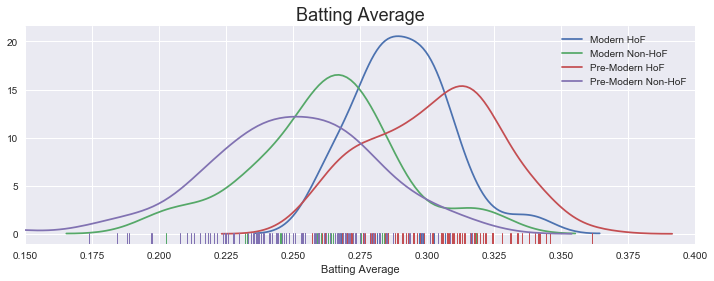

In [9]:
fig = plt.figure(figsize=(12,4))

axes = sns.distplot(sum_hof_batting_modern['AVG'], hist=False, rug=True, label='Modern HoF')
axes = sns.distplot(sample_batting_modern['AVG'], hist=False, rug=True, label='Modern Non-HoF')
axes = sns.distplot(sum_hof_batting_pre_modern['AVG'], hist=False, rug=True, label='Pre-Modern HoF')
axes = sns.distplot(sample_batting_pre_modern['AVG'], hist=False, rug=True, label='Pre-Modern Non-HoF')
axes.set_xlim([.15, .40])
axes.set_title("Batting Average", fontsize=18)
axes.set_xlabel("Batting Average")
xticks = [.150, .175, .200, .225, .250, .275, .300, .325, .350, .375, .400]
axes.set_xticks(xticks)
axes.set_xticklabels(['{:3.3f}'.format(x) for x in xticks])

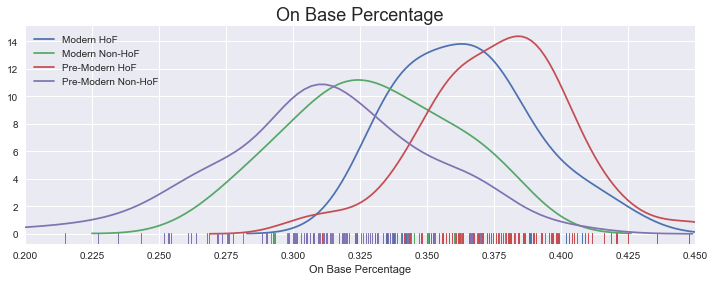

In [10]:
fig = plt.figure(figsize=(12,4))

#axes1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes = sns.distplot(sum_hof_batting_modern['OBP'], hist=False, rug=True, label='Modern HoF')
axes = sns.distplot(sample_batting_modern['OBP'], hist=False, rug=True, label='Modern Non-HoF')
axes = sns.distplot(sum_hof_batting_pre_modern['OBP'], hist=False, rug=True, label='Pre-Modern HoF')
axes = sns.distplot(sample_batting_pre_modern['OBP'], hist=False, rug=True, label='Pre-Modern Non-HoF')
axes.set_xlim([.20, .45])
axes.set_title("On Base Percentage", fontsize=18)
axes.set_xlabel("On Base Percentage")
axes.set_xlim(.200, .450)
xticks = [.200, .225, .250, .275, .300, .325, .350, .375, .400, .425, .450]
axes.set_xticks(xticks)
axes.set_xticklabels(['{:3.3f}'.format(x) for x in xticks])

#### Home Runs

It is interesting to look at the KDE curve for non-Hall of Famers (1st chart below) because the line for the pre-modern group is highly skewed toward zero, suggesting that a large number of non-HoF players in the pre-modern era hit very few home runs. This idea is supported by the fact that the cumulative mean for this group was just 25.  The curve for non-HoF players in the modern era is flat, tapers off gradually beginning around 50 home runs. The cumulative mean for this group is 92. 

Similarly, the peak of the KDE line for pre-modern HoF players is right at 100 home runs (2nd chart below), whereas for the modern group the peak is about three times as high. Combine all this with the fact that the mean home runs for modern Hall of Famers is 336 compared to 204 for pre-modern Hall of Famers, and you get a strong suggestion that hitting home runs is far more frequent today. Interestingly enough, however, this contrasts with batting averages, which have remained relatively equal for non-HoF players, but have dropped for modern-HoF players relative to the past. What does this mean with regard to Hall of Fame induction? Is a player more likely to be inducted into the Hall of Fame if he hits more home runs as opposed to having a better batting average? Does the home run have a greater impact on today's game compared with the past? Further study would be needed to explore these questions, but suffice it to say that the charts below and the statistics above do raise some interesting questions.

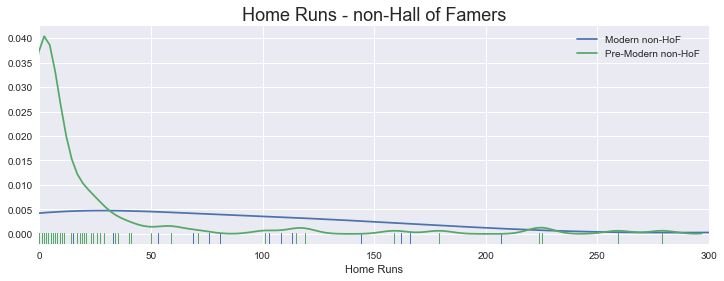

In [15]:
fig = plt.figure(figsize=(12,4))

axes = sns.distplot(sample_batting_modern['HR'], hist=False, rug=True, label='Modern non-HoF')
axes = sns.distplot(sample_batting_pre_modern['HR'], hist=False, rug=True, label='Pre-Modern non-HoF')
axes.set_xlim([0, 300])
axes.set_title("Home Runs - non-Hall of Famers", fontsize=18)
axes.set_xlabel("Home Runs")

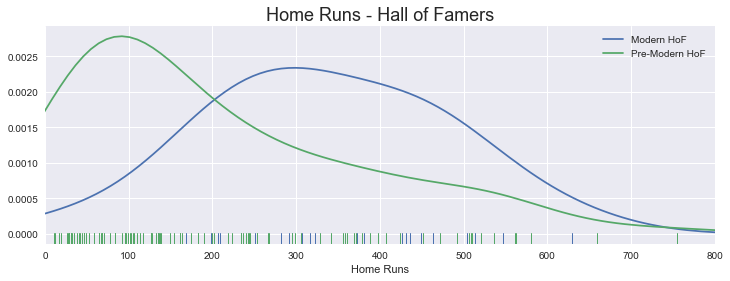

In [11]:
fig = plt.figure(figsize=(12,4))

axes = sns.distplot(sum_hof_batting_modern['HR'], hist=False, rug=True, label='Modern HoF')
axes = sns.distplot(sum_hof_batting_pre_modern['HR'], hist=False, rug=True, label='Pre-Modern HoF')
axes.set_xlim([0, 800])
axes.set_title("Home Runs - Hall of Famers", fontsize=18)
axes.set_xlabel("Home Runs")

#### Home Runs vs. Batting Average

Below are scatterplots for each of the four categories comparing home runs vs. batting average. I had anticipated a clear correlation between batting average and home runs, assuming that a player with a higher batting average would be more likely to hit home runs. However, the scatterplots suggest very little relationship between the number of home runs hit and batting average.

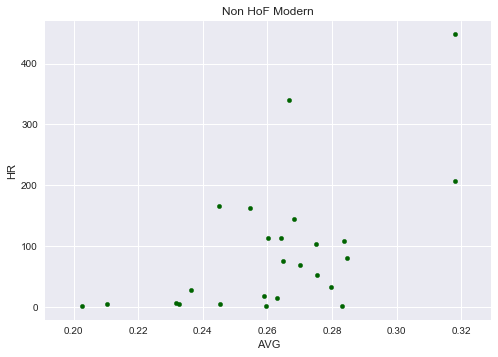

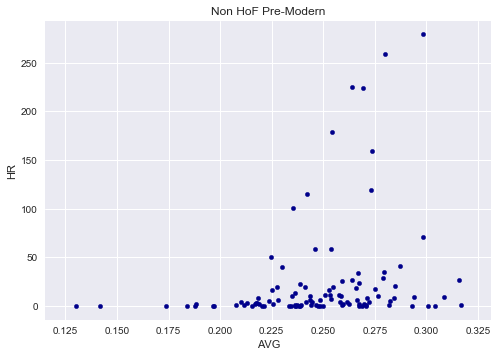

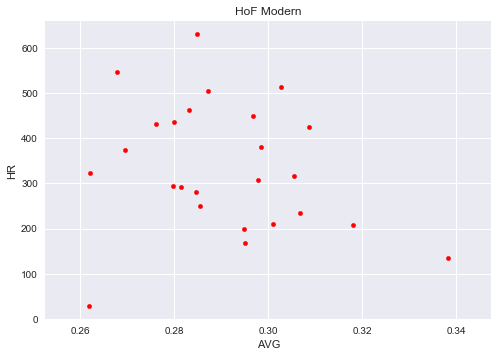

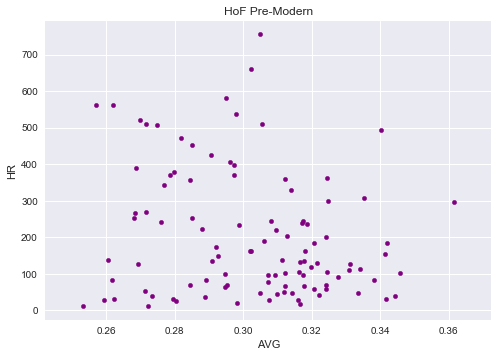

In [13]:
sample_batting_modern.plot.scatter(x="AVG", y="HR", color='DarkGreen', title="Non HoF Modern")
sample_batting_pre_modern.plot.scatter(x="AVG", y="HR", color='DarkBlue', title='Non HoF Pre-Modern')
sum_hof_batting_modern.plot.scatter(x="AVG", y="HR", color='Red', title='HoF Modern')
sum_hof_batting_pre_modern.plot.scatter(x="AVG", y="HR", color='Purple', title='HoF Pre-Modern')

#### Summary

I have explored data related to baseball, primarily looking at variables affecting Hall of Fame induction and ways in which the game has changed from the past to the present. This investigation is just a beginning phase. No conclusions can be drawn from the data presented; however, a number of intriguing questions have emerged. For instance, is there a stronger correlation between home runs hit and hall of fame induction as compared to batting average and Hall of Fame induction? To what can we attribute the relative drop in batting average among modern hall of famers and the relative rise in home runs, especially given that there is not a corresponding drop in batting average among modern non-hall of famers? 

The investigation presented in this notebook makes for a good initial exploration. Perhaps I will get the chance to explore these questions further in the future. 

### References

1. Data courtesy of [Sean Lahman at SeanLahman.com](http://www.seanlahman.com/baseball-archive/statistics/).
2. Jayson Stark, ["Drawing the Line at 1969"](http://www.espn.com/mlb/columns/story?columnist=stark_jayson&id=2471349 "ESPN.com"), makes the case for 1969 as the beginning of the "Modern Era" of baseball.
3. Myles Callan, Udacity Forum mentor, showed me how to remove pitchers from the batting database using the .isin() method.
4. Python Software Foundation - [Python Documentation](https://docs.python.org/2/), various topics: DataFrames, time, datetime, .isin(), matplotlib
5. [Stackoverflow](https://stackoverflow.com/), various topics: DataFrames, time, datetime. isin(), matplotlib
6. [pandas 0.20.3 documentation ](http://pandas.pydata.org/pandas-docs/stable/index.html), various topics: data structures, groupby, merge
7. [Seaborn](http://seaborn.pydata.org/index.html), various topics: distplot, histogram, KDE, titles, xticks, xlabel